# DAY4(21/07/04)
## NLP EDA : 자연어 처리에서 EDA를 통해 데이터 시각화로 데이터에 대한 이해를 높이기 위한 과정이다.
### 1. EDA가 필요한 이유 : 대부분 모델링을 통해 학습을 진행하고, 성능을 테스트 했을 때, 성능이 생각보다 좋지 않다면 다른 모델을 사용해보거나 추가적으로 하이퍼 파라미터 튜닝을 변경해본다. 하지만 이 과정을 진행하기 이전에, 데이터에 대한 이해도가 높은 상태에서 전처리가 잘 이루어져 있어야 한다. 이 과정들을 거치면서 EDA를 진행하고, 해당 데이터에 대한 이해를 바탕으로 가장 적합한 모델을 선택해보는 방식으로 접근을 해야 한다. 그래서 자연어 데이터의 경우, 문자들의 길이나 분포들을 파악하면서 이상치를 제거하여 학습의 효율성을 올려야 할 것이다.

### 2. 데이터 전처리를 한 후, 감성 분류 모델링을 진행할 것이다.


### 1. IMDB 데이터 호출

In [ ]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
import nltk
from nltk.corpus import stopwords

nltk.download('all')
stops = set(stopwords.words('english'))

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split



data_set = tf.keras.utils.get_file(
    fname = 'imdb.tar.gz',
    origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    extract = True
)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [ ]:
data_set

'/root/.keras/datasets/imdb.tar.gz'

In [ ]:
def directory_data(directory):
    data = {}
    data['review'] = []
    for file_path in os.listdir(directory):
        with open(os.path.join(directory, file_path), 'r') as file :
            data['review'].append(file.read())

    return pd.DataFrame.from_dict(data)


def data(directory):
    pos = directory_data(os.path.join(directory, 'pos'))
    neg = directory_data(os.path.join(directory, 'neg'))
    pos['sentiment'] = 1
    neg['sentiment'] = 0

    return pd.concat([pos, neg])

In [ ]:
train = data(os.path.join(os.path.dirname(data_set), 'aclImdb', 'train'))

### 2. EDA 진행

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 12499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 585.9+ KB


In [ ]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [ ]:
train

review  sentiment
0      To me, the final scene, in which Harris respon...          1
1      Sarah Silverman is a dangerous Bitch! She's be...          1
2      This is a small film , few characters ,theatri...          1
3      Berlin-born in 1942 Margarethe von Trotta was ...          1
4      David Beckham is a British soccer star and the...          1
...                                                  ...        ...
12495  Overrated and only for those people in their 2...          0
12496  How a director of Altman's experience could ev...          0
12497  Once in a while you get amazed over how BAD a ...          0
12498  A couple move into their dream home, unaware t...          0
12499  I hated this movie so much I remember it vivid...          0

[25000 rows x 2 columns]

In [ ]:
reviews = list(train['review'])
reviews

['To me, the final scene, in which Harris responds to the press corp, is worthy of viewing this intelligent and timeless slice of politics(especially the campaign phase). If only the "real-life" pols would respond in the intelligent, articulate manner as did Mr Harris,then the arrogant, self-serving members of the press would perhaps think twice before surfacing irrelevant, confrontational "garbage" that has absolutely nothing to do with a candidates abilities to effectively handle the challenges of the office for which he/she is pursuing.',
 "Sarah Silverman is a dangerous Bitch! She's beautiful, sexy, funny and talent, dark and demonic. I read the other 'comment' on this show as well as the message board stuff and people just don't get it. Nothing that appears on T.V. is an accident. Too much money, time and work is put into the production of a T.V. show for there to be mistakes. This show is stupid because Sarah wanted it to be stupid. This show is juvenile because Sarah wanted it t

#### 위에 문장을 살펴보니, 텍스트 전처리가 필요할 것으로 보여진다.

### 2-1. 불용어 사전 재정의
#### nltk에서 제공하는 불용어 사전에서 알파벳도 포함이 되어서 이를 활용하면 문자 자체가 망가지기 때문에 불용어 사전에 있는 알파벳은 모두 제거해줌.

In [ ]:
stop = []
for i in stops:
    if len(i) != 1:
        stop.append(i)
stops = set(stop)
stops

{'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 'same',
 'shan',
 "shan't

In [ ]:
def clean_text(sent):
    sent = sent.replace('<br />', '') #html에서 나오는 br 제거해줌.
    sent_clean = re.sub(r"[^a-zA-z ]", " ", sent).lower() #정규표현식을 통해 알파벳과 띄어쓰기, 숫자만 남기고 모두 제거
    no_stops =[word for word in sent_clean if not word in stops] # 불용어 처리
    sent = ''.join(no_stops) #불용어 처리 후 다시 재결합
    sent = sent.split()
    a =[word for word in sent if len(word) != 1]
    sent = ' '.join(a)
    

    return sent

In [ ]:
train['review'] = train['review'].apply(clean_text)

In [ ]:
train

review  sentiment
0      to me the final scene in which harris responds...          1
1      sarah silverman is dangerous bitch she beautif...          1
2      this is small film few characters theatrical a...          1
3      berlin born in margarethe von trotta was an ac...          1
4      david beckham is british soccer star and the h...          1
...                                                  ...        ...
12495  overrated and only for those people in their w...          0
12496  how director of altman experience could ever e...          0
12497  once in while you get amazed over how bad film...          0
12498  couple move into their dream home unaware that...          0
12499  hated this movie so much remember it vividly i...          0

[25000 rows x 2 columns]

In [ ]:
reviews = list(train['review'])
reviews

['to me the final scene in which harris responds to the press corp is worthy of viewing this intelligent and timeless slice of politics especially the campaign phase if only the real life pols would respond in the intelligent articulate manner as did mr harris then the arrogant self serving members of the press would perhaps think twice before surfacing irrelevant confrontational garbage that has absolutely nothing to do with candidates abilities to effectively handle the challenges of the office for which he she is pursuing',
 'sarah silverman is dangerous bitch she beautiful sexy funny and talent dark and demonic read the other comment on this show as well as the message board stuff and people just don get it nothing that appears on is an accident too much money time and work is put into the production of show for there to be mistakes this show is stupid because sarah wanted it to be stupid this show is juvenile because sarah wanted it to be juvenile thought the jokes were great and 

In [ ]:
# 문장 리스트를 토크나이징
tokenized_reviews = [r.split() for r in reviews]

#토큰화가 된 리스트에 대한 길이를 저장
review_len_by_token = [len(i) for i in tokenized_reviews]

#토큰화된 것들을 붙여서 음절의 길이로 저장
review_len_by = [len(s.replace(' ', '')) for s in reviews]

In [ ]:
tokenized_reviews

[['to',
  'me',
  'the',
  'final',
  'scene',
  'in',
  'which',
  'harris',
  'responds',
  'to',
  'the',
  'press',
  'corp',
  'is',
  'worthy',
  'of',
  'viewing',
  'this',
  'intelligent',
  'and',
  'timeless',
  'slice',
  'of',
  'politics',
  'especially',
  'the',
  'campaign',
  'phase',
  'if',
  'only',
  'the',
  'real',
  'life',
  'pols',
  'would',
  'respond',
  'in',
  'the',
  'intelligent',
  'articulate',
  'manner',
  'as',
  'did',
  'mr',
  'harris',
  'then',
  'the',
  'arrogant',
  'self',
  'serving',
  'members',
  'of',
  'the',
  'press',
  'would',
  'perhaps',
  'think',
  'twice',
  'before',
  'surfacing',
  'irrelevant',
  'confrontational',
  'garbage',
  'that',
  'has',
  'absolutely',
  'nothing',
  'to',
  'do',
  'with',
  'candidates',
  'abilities',
  'to',
  'effectively',
  'handle',
  'the',
  'challenges',
  'of',
  'the',
  'office',
  'for',
  'which',
  'he',
  'she',
  'is',
  'pursuing'],
 ['sarah',
  'silverman',
  'is',
  'dan

In [ ]:
review_len_by_token

[86,
 185,
 71,
 1134,
 261,
 228,
 265,
 179,
 551,
 341,
 119,
 217,
 47,
 320,
 411,
 110,
 95,
 709,
 63,
 117,
 112,
 309,
 170,
 232,
 178,
 133,
 173,
 173,
 208,
 454,
 544,
 112,
 124,
 125,
 68,
 245,
 121,
 504,
 77,
 293,
 139,
 825,
 144,
 284,
 156,
 194,
 140,
 133,
 150,
 121,
 627,
 103,
 297,
 226,
 129,
 330,
 933,
 343,
 127,
 116,
 125,
 408,
 124,
 138,
 327,
 138,
 115,
 383,
 424,
 83,
 105,
 219,
 119,
 120,
 151,
 170,
 121,
 115,
 180,
 55,
 243,
 119,
 205,
 196,
 140,
 167,
 102,
 77,
 39,
 82,
 80,
 256,
 152,
 137,
 152,
 170,
 69,
 331,
 153,
 122,
 193,
 287,
 178,
 405,
 133,
 142,
 160,
 287,
 771,
 104,
 131,
 136,
 193,
 286,
 176,
 145,
 176,
 207,
 192,
 102,
 138,
 56,
 433,
 285,
 122,
 132,
 182,
 568,
 114,
 128,
 236,
 173,
 221,
 223,
 118,
 117,
 145,
 336,
 478,
 123,
 87,
 148,
 375,
 420,
 147,
 706,
 185,
 168,
 201,
 110,
 84,
 120,
 87,
 173,
 242,
 215,
 122,
 296,
 127,
 117,
 155,
 152,
 254,
 272,
 83,
 58,
 271,
 96,
 105,
 199,


In [ ]:
review_len_by

[443,
 822,
 313,
 5632,
 1173,
 983,
 1217,
 786,
 2398,
 1705,
 515,
 1006,
 217,
 1498,
 1846,
 532,
 422,
 3629,
 262,
 570,
 487,
 1193,
 705,
 946,
 853,
 556,
 738,
 849,
 951,
 1821,
 2468,
 460,
 554,
 549,
 338,
 1161,
 535,
 2419,
 356,
 1446,
 599,
 3693,
 583,
 1310,
 694,
 853,
 713,
 636,
 680,
 489,
 2853,
 447,
 1425,
 980,
 563,
 1539,
 4309,
 1599,
 619,
 585,
 540,
 1869,
 513,
 646,
 1532,
 602,
 555,
 1641,
 1981,
 373,
 504,
 1029,
 558,
 501,
 654,
 675,
 505,
 537,
 755,
 289,
 1005,
 527,
 863,
 895,
 568,
 758,
 491,
 361,
 212,
 363,
 358,
 1126,
 726,
 558,
 754,
 783,
 303,
 1482,
 635,
 542,
 917,
 1308,
 827,
 1921,
 652,
 578,
 681,
 1215,
 3672,
 504,
 573,
 597,
 856,
 1242,
 727,
 670,
 823,
 916,
 846,
 471,
 614,
 252,
 2015,
 1297,
 553,
 585,
 825,
 2544,
 481,
 611,
 1209,
 833,
 1019,
 1055,
 538,
 525,
 669,
 1509,
 2253,
 537,
 400,
 670,
 1593,
 1904,
 712,
 3228,
 788,
 697,
 940,
 529,
 395,
 536,
 390,
 829,
 1036,
 989,
 549,
 1311,
 600

#### 길이를 시각화해보자.

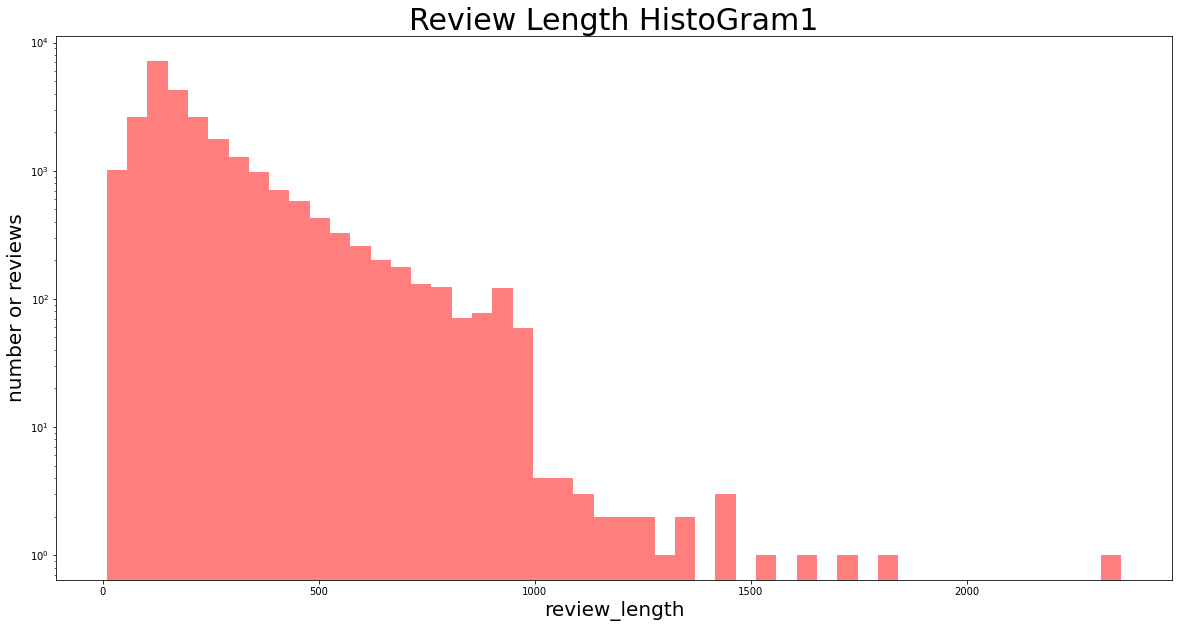

In [ ]:
plt.figure(figsize = (20, 10))
plt.hist(review_len_by_token, bins = 50, alpha = 0.5, color = 'r', label = 'word') 
## bins = 히스토그램에 대한 버킷 범위
plt.yscale('log', nonposy = 'clip')
plt.title('Review Length HistoGram1', fontsize = 30)
plt.xlabel('review_length', fontsize = 20)
plt.ylabel('number or reviews', fontsize = 20)
plt.show()

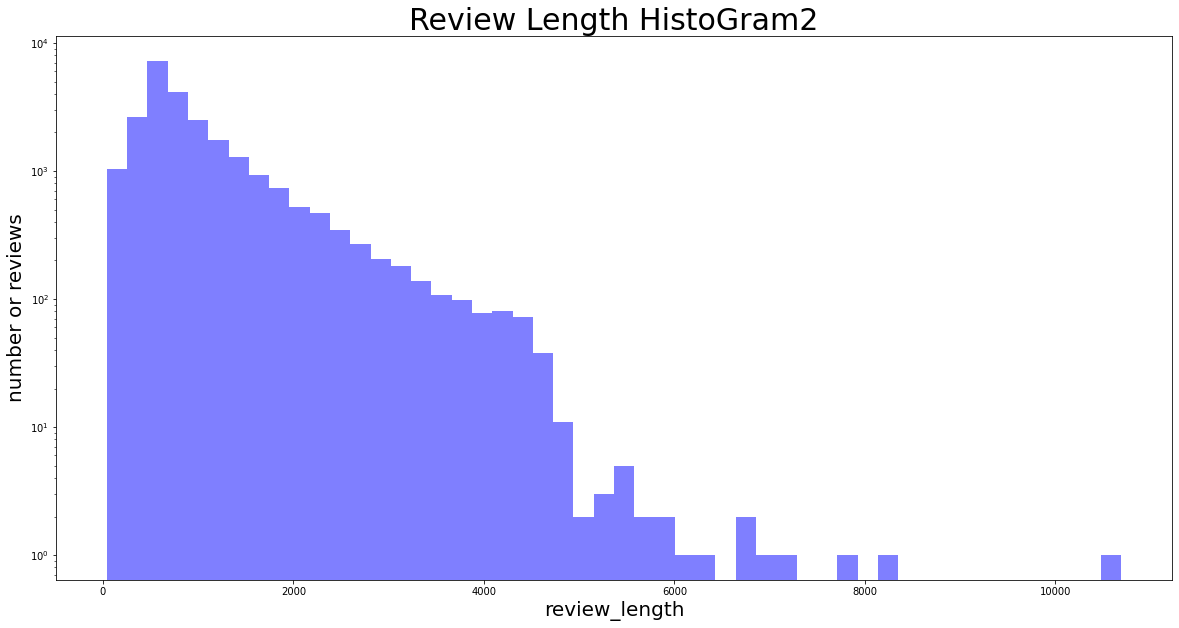

In [ ]:
plt.figure(figsize = (20, 10))
plt.hist(review_len_by, bins = 50, alpha = 0.5, color = 'b', label = 'alphabet') 
## bins = 히스토그램에 대한 버킷 범위
plt.yscale('log', nonposy = 'clip')
plt.title('Review Length HistoGram2', fontsize = 30)
plt.xlabel('review_length', fontsize = 20)
plt.ylabel('number or reviews', fontsize = 20)
plt.show()

문장 최대의 길이 :2358
문장 최소의 길이 :9
문장 평균 길이 :222.07468
문장 길이 표준 편차 :166.4248476126615
문장 중간 길이 :165.0
제 1사분위 길이:120.0
제 3사분위 길이:269.0


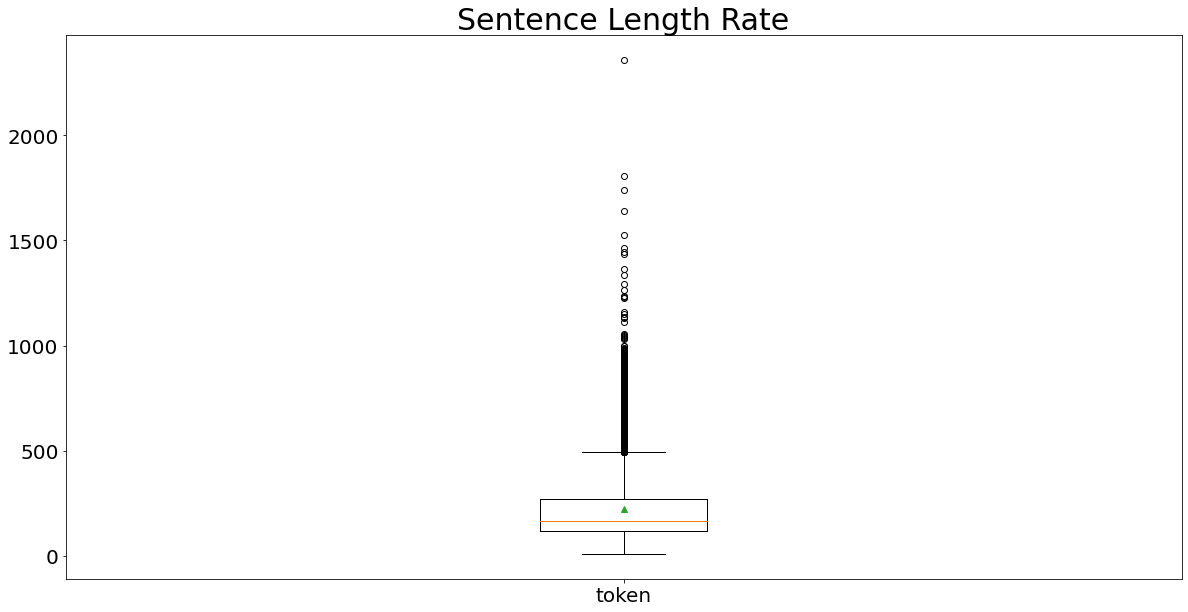

In [ ]:
print('문장 최대의 길이 :{}'.format(np.max(review_len_by_token)))
print('문장 최소의 길이 :{}'.format(np.min(review_len_by_token)))
print('문장 평균 길이 :{}'.format(np.mean(review_len_by_token)))
print('문장 길이 표준 편차 :{}'.format(np.std(review_len_by_token)))
print('문장 중간 길이 :{}'.format(np.median(review_len_by_token)))

print('제 1사분위 길이:{}'.format(np.percentile(review_len_by_token, 25)))
print('제 3사분위 길이:{}'.format(np.percentile(review_len_by_token, 75)))

plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Sentence Length Rate', fontsize = 30)
plt.boxplot([review_len_by_token], labels=['token'], showmeans = True)
plt.show();

음절 최대의 길이 :10693
음절 최소의 길이 :40
음절 평균 길이 :1012.84312
음절 길이 표준 편차 :772.9542607093033
음절 중간 길이 :747.0
제 1사분위 길이:535.0
제 3사분위 길이:1230.0


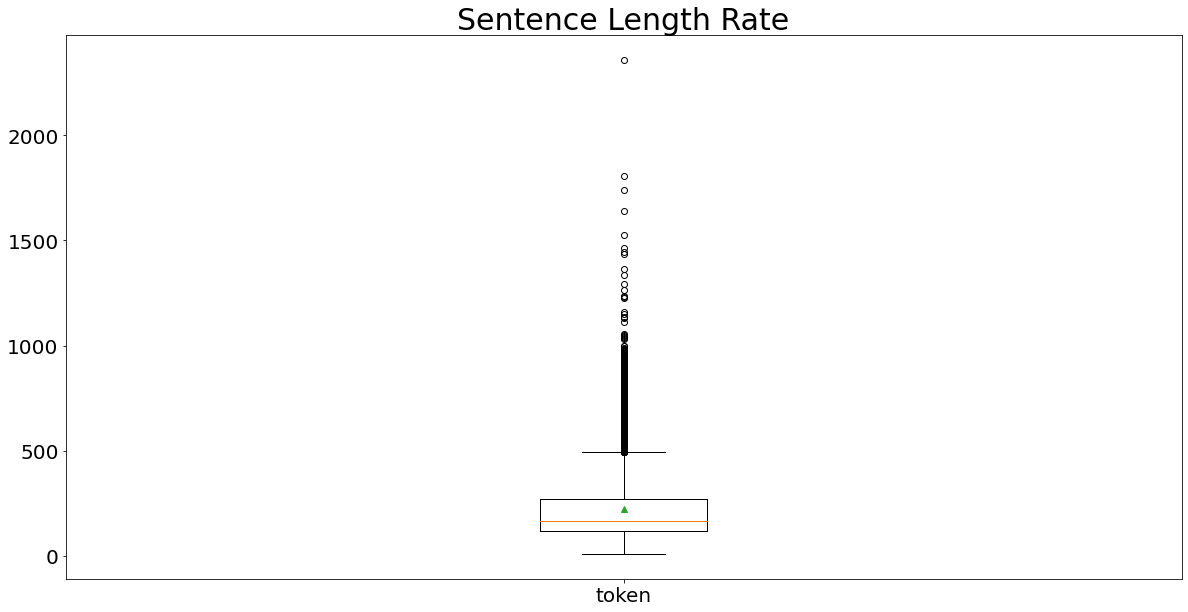

In [ ]:
print('음절 최대의 길이 :{}'.format(np.max(review_len_by)))
print('음절 최소의 길이 :{}'.format(np.min(review_len_by)))
print('음절 평균 길이 :{}'.format(np.mean(review_len_by)))
print('음절 길이 표준 편차 :{}'.format(np.std(review_len_by)))
print('음절 중간 길이 :{}'.format(np.median(review_len_by)))

print('제 1사분위 길이:{}'.format(np.percentile(review_len_by, 25)))
print('제 3사분위 길이:{}'.format(np.percentile(review_len_by, 75)))

plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.ylabel('', fontsize = 20)
plt.title('Sentence Length Rate', fontsize = 30)
plt.boxplot([review_len_by_token], labels=['token'], showmeans = True)
plt.show();

#### 박스플롯을 확인해보면, 문장과 음절의 길이 모두 이상치가 심한 데이터인 것을 확인할 수 있다.
#### 이상치가 있는 데이터는 제거해주고 모델링을 진행해보겠다.

In [ ]:
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

wordcloud = WordColud(stopwords = STOPWORDS, 
                      background_color = 'black', 
                      width = 800,
                      height = 600).generate(' '.join(train['review']))

In [ ]:
plt.figure(figsize = (20, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Target Ratio', fontsize = 30)
sns.countplot(train['sentiment'])

In [ ]:
train['review']

0        to me the final scene in which harris responds...
1        sarah silverman is dangerous bitch she beautif...
2        this is small film few characters theatrical a...
3        berlin born in margarethe von trotta was an ac...
4        david beckham is british soccer star and the h...
                               ...                        
12495    overrated and only for those people in their w...
12496    how director of altman experience could ever e...
12497    once in while you get amazed over how bad film...
12498    couple move into their dream home unaware that...
12499    hated this movie so much remember it vividly i...
Name: review, Length: 25000, dtype: object

In [ ]:
train1 = train.reset_index(drop = True)
train1['length'] = train1['review'].apply(lambda x :len(x))
train1

review  sentiment  length
0      to me the final scene in which harris responds...          1     528
1      sarah silverman is dangerous bitch she beautif...          1    1006
2      this is small film few characters theatrical a...          1     383
3      berlin born in margarethe von trotta was an ac...          1    6765
4      david beckham is british soccer star and the h...          1    1433
...                                                  ...        ...     ...
24995  overrated and only for those people in their w...          0     600
24996  how director of altman experience could ever e...          0     769
24997  once in while you get amazed over how bad film...          0     238
24998  couple move into their dream home unaware that...          0     931
24999  hated this movie so much remember it vividly i...          0     340

[25000 rows x 3 columns]

In [ ]:
train1['length'].quantile(0.9)

2440.0

In [ ]:
train1['length'].describe()

count    25000.000000
mean      1233.917800
std        938.915788
min         48.000000
25%        654.000000
50%        910.000000
75%       1499.000000
max      13050.000000
Name: length, dtype: float64

In [ ]:
train1['length'].quantile(0.85), train1['length'].quantile(0.05)

(2013.0, 332.0)

In [ ]:
train1 = train1[(train1['length'] > 300) & (train1['length'] < 2000)]
train1 = train1.reset_index(drop = True)
train1

review  sentiment  length
0      to me the final scene in which harris responds...          1     528
1      sarah silverman is dangerous bitch she beautif...          1    1006
2      this is small film few characters theatrical a...          1     383
3      david beckham is british soccer star and the h...          1    1433
4      kazan early film noir won an oscar some of the...          1    1210
...                                                  ...        ...     ...
20238  during the civil war there were many cases of ...          0     754
20239  overrated and only for those people in their w...          0     600
20240  how director of altman experience could ever e...          0     769
20241  couple move into their dream home unaware that...          0     931
20242  hated this movie so much remember it vividly i...          0     340

[20243 rows x 3 columns]

### 3. 텍스트 벡터화 및 학습 / 검증 데이터 분리 진행

In [ ]:
def token(data):
    token = Tokenizer()
    token.fit_on_texts(data)
    sequences = token.texts_to_sequences(data)
    sequences = pad_sequences(sequences)
    word_index = token.word_index
    
    return sequences, word_index

In [ ]:
X_train = token(train1['review'])[0]
X_train

array([[    0,     0,     0, ...,    59,     5, 10681],
       [    0,     0,     0, ...,   198,    40,    35],
       [    0,     0,     0, ...,    20,   270,  1043],
       ...,
       [    0,     0,     0, ...,  4014,  2229,  4783],
       [    0,     0,     0, ...,   686,    34,     6],
       [    0,     0,     0, ...,    18,     8,    22]], dtype=int32)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train1['sentiment'], test_size = 0.2 , random_state = 411)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16194, 392), (4049, 392), (16194,), (4049,))

In [ ]:
train_pre = token(train['review'])[0]
train_pre

array([[   0,    0,    0, ...,   48,    5, 7787],
       [   0,    0,    0, ...,  180,   40,   35],
       [   0,    0,    0, ...,   21,  251,  951],
       ...,
       [   0,    0,    0, ..., 2091,  108,  465],
       [   0,    0,    0, ...,  721,   33,    6],
       [   0,    0,    0, ...,   18,    8,   25]], dtype=int32)

In [ ]:
X_train_pre, X_val_pre, y_train_pre, y_val_pre = train_test_split(train_pre, train['sentiment'], test_size = 0.2 , random_state = 411)
X_train_pre.shape, X_val_pre.shape, y_train_pre.shape, y_val_pre.shape

((20000, 2358), (5000, 2358), (20000,), (5000,))

In [ ]:
X_train_pre.shape

(20000, 2358)

### 4. LSTM 모델 생성

#### 우선적으로, 이상치를 제거한 데이터로 학습 및 성능 검증을 실시해보도록 한다.

In [ ]:
len(token(train1['review'])[0])+1

20244

In [ ]:
model_name = 'lstmmodel'
batch_size = 64
num_epochs = 20

kargs = {'model_name' : model_name,
         'vocab_size' : len(token(train1['review'])[1])+1,
         'embedding_dimension' : 128,
         'dropout_rate' : 0.5,
         'lstm_dimension' : 256,
         'dense_dimension' : 256,
         'output_dimension' : 1}


In [ ]:
class LstmModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(LstmModel, self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = LstmModel(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16194, 392), (4049, 392), (16194,), (4049,))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 5)
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/20
254/254 [==============================] - 34s 121ms/step - loss: 0.6265 - accuracy: 0.6159 - val_loss: 0.4103 - val_accuracy: 0.8298
Epoch 2/20
254/254 [==============================] - 30s 118ms/step - loss: 0.3590 - accuracy: 0.8505 - val_loss: 0.3164 - val_accuracy: 0.8671
Epoch 3/20
254/254 [==============================] - 30s 119ms/step - loss: 0.2497 - accuracy: 0.9018 - val_loss: 0.3186 - val_accuracy: 0.8661
Epoch 4/20
254/254 [==============================] - 30s 118ms/step - loss: 0.1965 - accuracy: 0.9240 - val_loss: 0.3533 - val_accuracy: 0.8614
Epoch 5/20
254/254 [==============================] - 30s 118ms/step - loss: 0.2066 - accuracy: 0.9203 - val_loss: 0.2876 - val_accuracy: 0.8852
Epoch 6/20
254/254 [==============================] - 30s 118ms/step - loss: 0.1320 - accuracy: 0.9542 - val_loss: 0.3064 - val_accuracy: 0.8849
Epoch 7/20
254/254 [==============================] - 30s 118ms/step - loss: 0.1009 - accuracy: 0.9635 - val_loss: 0.3183 - val_ac

#### 이번엔, 이상치를 제거하지 않은 데이터로 학습 및 성능 검증을 진행해본다.

In [ ]:
kargs = {'model_name' : model_name,
         'vocab_size' : len(token(train['review'])[1])+1,
         'embedding_dimension' : 128,
         'dropout_rate' : 0.5,
         'lstm_dimension' : 256,
         'dense_dimension' : 256,
         'output_dimension' : 1}

class LstmModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(LstmModel, self).__init__(name=kargs['model_name'])
        self.embedding = tf.keras.layers.Embedding(input_dim = kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
        self.fc1 = tf.keras.layers.Dense(units = kargs['dense_dimension'], activation=tf.keras.activations.relu)
        self.fc2 = tf.keras.layers.Dense(units = kargs['output_dimension'], activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model_pre = LstmModel(**kargs)
model_pre.compile(optimizer = tf.keras.optimizers.Adam(1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 5)
history_pre = model_pre.fit(X_train_pre, y_train_pre, epochs = num_epochs, batch_size=batch_size, validation_data=(X_val_pre, y_val_pre), callbacks=[es])

Epoch 1/20
313/313 [==============================] - 165s 519ms/step - loss: 0.6009 - accuracy: 0.6477 - val_loss: 0.3777 - val_accuracy: 0.8404
Epoch 2/20
313/313 [==============================] - 162s 517ms/step - loss: 0.3258 - accuracy: 0.8651 - val_loss: 0.2858 - val_accuracy: 0.8870
Epoch 3/20
313/313 [==============================] - 161s 515ms/step - loss: 0.2297 - accuracy: 0.9124 - val_loss: 0.2675 - val_accuracy: 0.8918
Epoch 4/20
313/313 [==============================] - 161s 515ms/step - loss: 0.1747 - accuracy: 0.9365 - val_loss: 0.3253 - val_accuracy: 0.8886
Epoch 5/20
313/313 [==============================] - 161s 515ms/step - loss: 0.1394 - accuracy: 0.9489 - val_loss: 0.2994 - val_accuracy: 0.8848
Epoch 6/20
313/313 [==============================] - 161s 515ms/step - loss: 0.1292 - accuracy: 0.9535 - val_loss: 0.2977 - val_accuracy: 0.8930
Epoch 7/20
313/313 [==============================] - 161s 516ms/step - loss: 0.0852 - accuracy: 0.9707 - val_loss: 0.3344 -

#### 결론 : 이상치 처리된 데이터와 처리되지 않은 데이터의 성능은 88~89%로 비슷한 성능을 지닌다. 하지만, 학습 속도 면에서 5배나 빠른 것을 확인할 수 있었다.
#### 그렇다면 성능은 비슷하지만, 학습을 빨리한다는 관점에서 이상치 처리를 하는 것이 좋다고 볼 수 있다.

### 5. 느낀 점
#### 오늘은 불용어와 특수 문자 제거 등 실제 전처리 과정의 중요한 부분을 다룬 후, 시각화를 통해 이상치를 제거하는 것을 진행했다. 
#### 성능에서 크게 차이가 있을 거란 예상과는 달리, 성능 자체는 차이가 없었으나 학습 속도에서 큰 차이가 있다는 것을 눈으로 직접 확인할 수 있었다. 
#### EDA를 통해 데이터를 시각화하고, 데이터 분포를 파악하는 것 또한 모델링에 있어서 매우 중요하다는 것을 느낄 수 있는 시간이었다.